In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from multiprocessing import Pool
import re
import nltk
from nltk.stem import wordnet
from nltk import pos_tag
from nltk import word_tokenize # to create tokens
from nltk.corpus import stopwords
from nltk.corpus import stopwords, sentiwordnet as swn
from nltk.stem import WordNetLemmatizer

In [2]:
%matplotlib inline

In [3]:
with open('data_set.pickle', 'rb') as data:
    data_set = pickle.load(data)

### Preprocess the dataset

In [4]:
print(data_set.head())
print(data_set.count())

                                             content  rating  sentiment
0  i had my stay in radisson blu plaza airport. h...       5          1
1  Amazing stay, had breakfast at NYC and food wa...       5          1
2  It was a great experience especially the food ...       5          1
3  Had dinner at the NYC restuarant today. It was...       5          1
4  I was staying here for a couple of days.. it w...       5          1
content      6800
rating       6800
sentiment    6800
dtype: int64


In [5]:
# case text as lowercase, remove punctuation, remove extra whitespace in string and on both sides of string

data_set['content'] = data_set['content'].str.lower().str.replace("'", '').str.replace('[^\w\s]', ' ').str.replace(" \d+", " ").str.replace(' +', ' ').str.strip()

display(data_set.head(10))

<ipython-input-5-ff66dd013820>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data_set['content'] = data_set['content'].str.lower().str.replace("'", '').str.replace('[^\w\s]', ' ').str.replace(" \d+", " ").str.replace(' +', ' ').str.strip()


,content,rating,sentiment
0,i had my stay in radisson blu plaza airport ha...,5,1
1,amazing stay had breakfast at nyc and food was...,5,1
2,it was a great experience especially the food ...,5,1
3,had dinner at the nyc restuarant today it was ...,5,1
4,i was staying here for a couple of days it was...,5,1
5,visited the plaza for lunch buffet with family...,5,1
6,frequent visitor a nightmare dinner on july ru...,1,0
7,i came here for the very first time chekin was...,5,1
8,the food was yum and enjoyed every bit of it c...,5,1
9,delicious in nyc lunch buffet was so tasty app...,5,1


In [6]:
stop_words = stopwords.words('english')
data_set['st'] = data_set['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

display(data_set.head(10))

,content,rating,sentiment,st
0,i had my stay in radisson blu plaza airport ha...,5,1,stay radisson blu plaza airport breakfast nyc ...
1,amazing stay had breakfast at nyc and food was...,5,1,amazing stay breakfast nyc food great biew goo...
2,it was a great experience especially the food ...,5,1,great experience especially food entire meal m...
3,had dinner at the nyc restuarant today it was ...,5,1,dinner nyc restuarant today monsoon theme spre...
4,i was staying here for a couple of days it was...,5,1,staying couple days amazing stay staff friendl...
5,visited the plaza for lunch buffet with family...,5,1,visited plaza lunch buffet family food cuisine...
6,frequent visitor a nightmare dinner on july ru...,1,0,frequent visitor nightmare dinner july rude st...
7,i came here for the very first time chekin was...,5,1,came first time chekin quick smooth done komal...
8,the food was yum and enjoyed every bit of it c...,5,1,food yum enjoyed every bit crisha mr sandeep t...
9,delicious in nyc lunch buffet was so tasty app...,5,1,delicious nyc lunch buffet tasty appetizing am...


In [7]:
# function that performs text normalization steps

def text_normalization(text):
    text=str(text).lower() # text to lower case
    spl_char_text=re.sub(r'[^ a-z]','',text) # removing special characters
    tokens=nltk.word_tokenize(spl_char_text) # word tokenizing
    lema=wordnet.WordNetLemmatizer() # intializing lemmatization
    tags_list=pos_tag(tokens,tagset=None) # parts of speech
    lema_words=[]   # empty list 
    for token,pos_token in tags_list:
        if pos_token.startswith('V'):  # Verb
            pos_val='v'
        elif pos_token.startswith('J'): # Adjective
            pos_val='a'
        elif pos_token.startswith('R'): # Adverb
            pos_val='r'
        else:
            pos_val='n' # Noun
        lema_token=lema.lemmatize(token,pos_val) # performing lemmatization
        lema_words.append(lema_token) # appending the lemmatized token into a list
    
    return " ".join(lema_words) # returns the lemmatized tokens as a sentence 

In [8]:
data_set['cleaned_text']=data_set['st'].apply(text_normalization) # applying the fuction to the dataset to get clean text
data_set.tail(15)

,content,rating,sentiment,st,cleaned_text
6785,date dec we had missed the flight and needed a...,4,1,date dec missed flight needed hotel one night ...,date dec miss flight need hotel one night turn...
6786,stayed here in early december for one night ne...,5,1,stayed early december one night needed close a...,stay early december one night need close airpo...
6787,i note mixed comments in other reports but we ...,4,1,note mixed comments reports found staff helpfu...,note mixed comment report find staff helpful r...
6788,stayed here for nights one at the beginning of...,2,0,stayed nights one beginning holiday one end ge...,stay night one begin holiday one end general h...
6789,it was a relief to see the man with the radiss...,4,1,relief see man radisson sign left dump delhi a...,relief see man radisson sign leave dump delhi ...
6790,it was very important to find a safe reliable ...,5,1,important find safe reliable hotel since woman...,important find safe reliable hotel since woman...
6791,this is a radisson by the airport that is abou...,3,0,radisson airport need know delivers expecation...,radisson airport need know delivers expecation...
6792,some of the most uncomfortable beds casual ser...,2,0,uncomfortable beds casual service attitude enc...,uncomfortable bed casual service attitude enco...
6793,we stayed in the radisson a total of nights du...,4,1,stayed radisson total nights golden triangle t...,stay radisson total night golden triangle tour...
6794,i travelled with a group and we mannaged to ge...,3,0,travelled group mannaged get rooms hotel last ...,travel group mannaged get room hotel last day ...


In [9]:
from textblob import TextBlob

In [10]:
# perform text preprocessing steps on the contents of data_set
processed_df = data_set.drop(['st'], axis = 1)


In [11]:
processed_df.head()

,content,rating,sentiment,cleaned_text
0,i had my stay in radisson blu plaza airport ha...,5,1,stay radisson blu plaza airport breakfast nyc ...
1,amazing stay had breakfast at nyc and food was...,5,1,amaze stay breakfast nyc food great biew good ...
2,it was a great experience especially the food ...,5,1,great experience especially food entire meal m...
3,had dinner at the nyc restuarant today it was ...,5,1,dinner nyc restuarant today monsoon theme spre...
4,i was staying here for a couple of days it was...,5,1,stay couple day amaze stay staff friendly coop...


In [12]:
import spacy

In [13]:
processed_df['senti_polar'] = processed_df['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity )

In [14]:
processed_df.head()

,content,rating,sentiment,cleaned_text,senti_polar
0,i had my stay in radisson blu plaza airport ha...,5,1,stay radisson blu plaza airport breakfast nyc ...,0.812500
1,amazing stay had breakfast at nyc and food was...,5,1,amaze stay breakfast nyc food great biew good ...,0.666667
2,it was a great experience especially the food ...,5,1,great experience especially food entire meal m...,0.235714
3,had dinner at the nyc restuarant today it was ...,5,1,dinner nyc restuarant today monsoon theme spre...,0.522619
4,i was staying here for a couple of days it was...,5,1,stay couple day amaze stay staff friendly coop...,0.395000


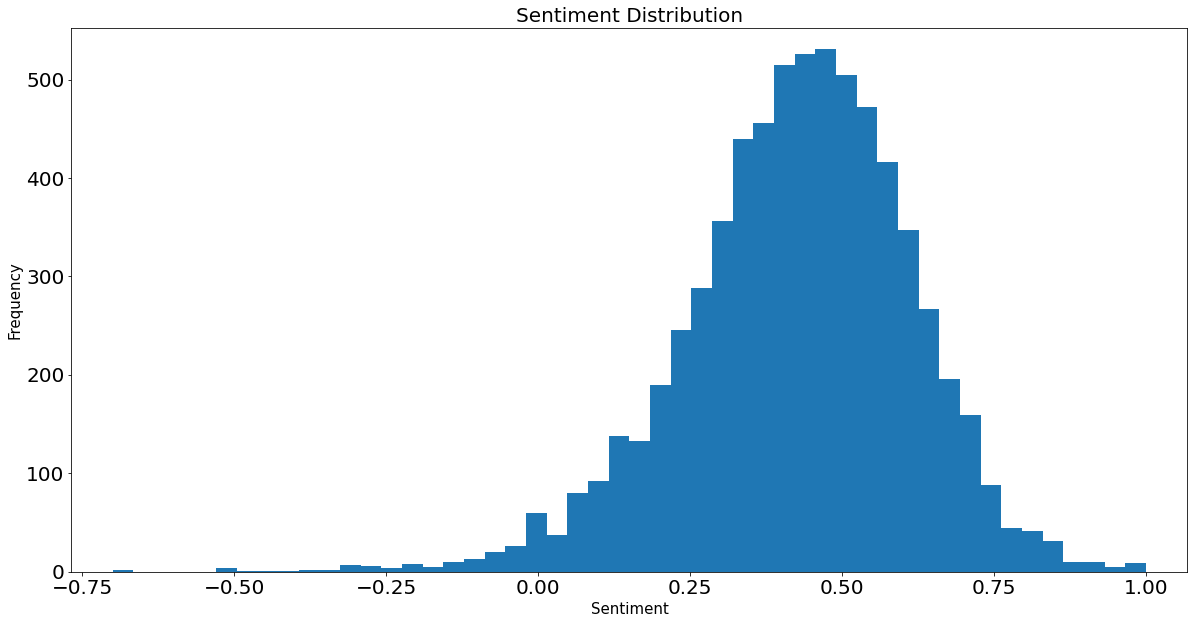

In [15]:
plt.figure(figsize=(20,10))
plt.margins(0.04)
plt.xlabel('Sentiment', fontsize=15)
plt.xticks(fontsize=20)
plt.ylabel('Frequency', fontsize=15)
plt.yticks(fontsize=20)
plt.hist(processed_df['senti_polar'], bins=50)
plt.title('Sentiment Distribution', fontsize=20)
plt.show()

In [16]:
afinn = pd.read_csv('Afinn.csv', sep=',', encoding='latin-1')
afinn.shape

(2477, 2)

In [17]:
afinn.head() 

,word,value
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


In [18]:
affinity_scores = afinn.set_index('word')['value'].to_dict() 

In [19]:
nlp = spacy.load('en_core_web_sm')
sentiment_lexicon = affinity_scores

def calculate_sentiment(text: str = None):
    sent_score = 0
    if text:
        sentence = nlp(text)
        for word in sentence:
            sent_score += sentiment_lexicon.get(word.lemma_, 0)
    return sent_score 

In [20]:
processed_df['sentiment_value'] = processed_df['cleaned_text'].apply(calculate_sentiment) 

In [21]:
processed_df.head()

,content,rating,sentiment,cleaned_text,senti_polar,sentiment_value
0,i had my stay in radisson blu plaza airport ha...,5,1,stay radisson blu plaza airport breakfast nyc ...,0.812500,13
1,amazing stay had breakfast at nyc and food was...,5,1,amaze stay breakfast nyc food great biew good ...,0.666667,16
2,it was a great experience especially the food ...,5,1,great experience especially food entire meal m...,0.235714,9
3,had dinner at the nyc restuarant today it was ...,5,1,dinner nyc restuarant today monsoon theme spre...,0.522619,8
4,i was staying here for a couple of days it was...,5,1,stay couple day amaze stay staff friendly coop...,0.395000,12


In [22]:
import seaborn as sns

In [23]:
processed_df['index']=range(0,len(processed_df)) 

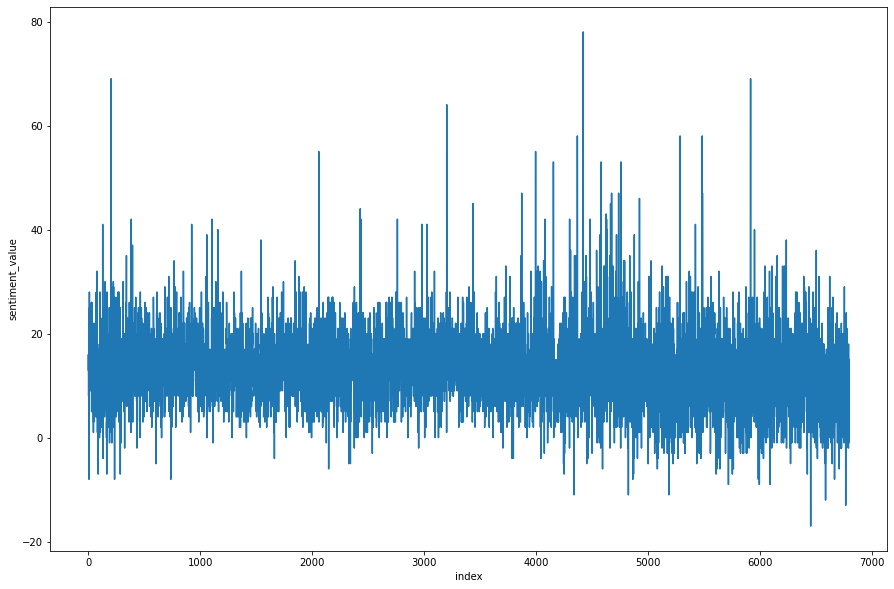

In [24]:
plt.figure(figsize=(15, 10))
sns.lineplot(y='sentiment_value',x='index',data=processed_df) 

In [28]:
processed_df['sentiment'] = processed_df['sentiment_value'].apply(lambda x : 'Positive' if x > 0 else ('Negative' if x<0 else 'Neutral'))

In [29]:
processed_df['sentiment']

0       Positive
1       Positive
2       Positive
3       Positive
4       Positive
          ...   
6795    Negative
6796    Negative
6797    Positive
6798    Positive
6799    Positive
Name: sentiment, Length: 6800, dtype: object

In [30]:
processed_df['sentiment'].value_counts()

Positive    6568
Negative     161
Neutral       71
Name: sentiment, dtype: int64

In [41]:
Negative_senti=processed_df[processed_df['sentiment_value']<0]

In [42]:
Negative_senti

,content,rating,sentiment,cleaned_text,senti_polar,sentiment_value,index
6,frequent visitor a nightmare dinner on july ru...,1,Negative,frequent visitor nightmare dinner july rude st...,-0.475000,-8,6
86,rain water was leaking from windows inside the...,2,Negative,rain water leak window inside room ask replace...,0.000000,-4,86
89,staff is really rude and doesnt serve on time ...,1,Negative,staff really rude doesnt serve time whatever t...,-0.500000,-7,89
132,very poor responce from customer care team don...,1,Negative,poor responce customer care team dont know con...,0.060000,-4,132
165,this time got last room on the floor very inco...,3,Negative,time get last room floor inconvenient travel l...,-0.260000,-7,165
...,...,...,...,...,...,...,...
6768,we stayed at the radisson in the luxury suite ...,1,Negative,stay radisson luxury suite pay high premium pr...,-0.150306,-13,6768
6774,i was traveling to nepal and had a stopover in...,1,Negative,travel nepal stopover delhi although room terr...,-0.147917,-2,6774
6792,some of the most uncomfortable beds casual ser...,2,Negative,uncomfortable bed casual service attitude enco...,-0.500000,-2,6792
6795,the reception staff and management at this hot...,1,Negative,reception staff management hotel probably drea...,-0.375000,-1,6795


In [43]:
display(processed_df.iloc[6768])

content            we stayed at the radisson in the luxury suite ...
rating                                                             1
sentiment                                                   Negative
cleaned_text       stay radisson luxury suite pay high premium pr...
senti_polar                                                -0.150306
sentiment_value                                                  -13
index                                                           6768
Name: 6768, dtype: object

In [44]:
processed_df.iloc[6768]

content            we stayed at the radisson in the luxury suite ...
rating                                                             1
sentiment                                                   Negative
cleaned_text       stay radisson luxury suite pay high premium pr...
senti_polar                                                -0.150306
sentiment_value                                                  -13
index                                                           6768
Name: 6768, dtype: object

In [ ]:
df

In [45]:
processed_df['sentiment'] = processed_df['sentiment'].replace({'Negative': -1})
processed_df['sentiment'] = processed_df['sentiment'].replace({'Positive': 1})
processed_df['sentiment'] = processed_df['sentiment'].replace({'Neutral': 0})

In [46]:
processed_df['sentiment']

0       1
1       1
2       1
3       1
4       1
       ..
6795   -1
6796   -1
6797    1
6798    1
6799    1
Name: sentiment, Length: 6800, dtype: int64

In [48]:
processed_df['sentiment'].value_counts()

 1    6568
-1     161
 0      71
Name: sentiment, dtype: int64

### Positive words cloud

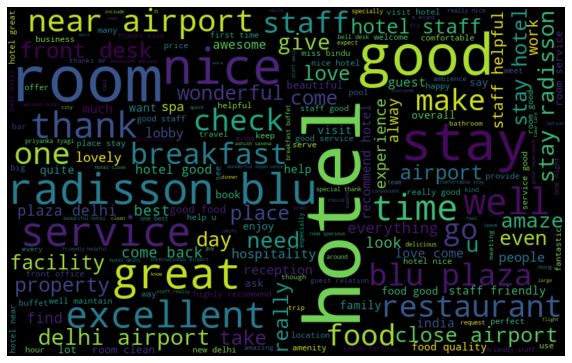

In [49]:
pos_words = ' '.join([text for text in processed_df['cleaned_text'][processed_df['sentiment'] == 1]])
pos_wordcloud = WordCloud(width=800, height=500, random_state=20, max_font_size=110).generate(pos_words)

plt.figure(figsize=(10,7))
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Negative words cloud

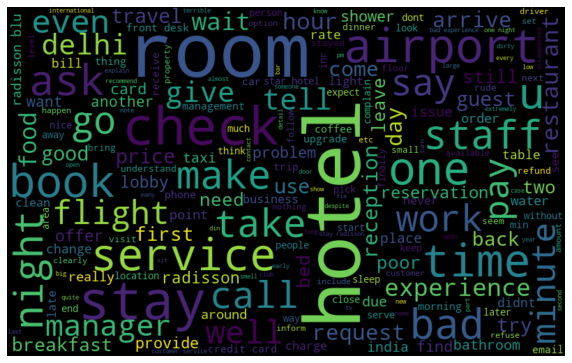

In [50]:
neg_words = ' '.join([text for text in processed_df['cleaned_text'][processed_df['sentiment'] == -1]])
neg_wordcloud = WordCloud(width=800, height=500, random_state=20, max_font_size=110).generate(neg_words)

plt.figure(figsize=(10,7))
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Complaints word cloud

### Split data for training and testing

In [51]:
X_train, X_test, Y_train, Y_test = train_test_split(processed_df['cleaned_text'], 
                                                    processed_df['sentiment'], 
                                                    test_size = 0.30,
                                                    random_state = 10)

In [52]:
print(X_train.shape)
print(X_test.shape)

(4760,)
(2040,)


### Create TFIDF vector

In [53]:
tfidf = TfidfVectorizer(encoding='utf-8',
                       ngram_range=(1,2),
                       max_df=1.0,
                       min_df=10,
                       max_features=300,
                       norm='l2',
                       sublinear_tf=True)

In [54]:
train_features = tfidf.fit_transform(X_train).toarray()
print(train_features.shape)

(4760, 300)


In [55]:
test_features = tfidf.transform(X_test).toarray()
print(test_features.shape)

(2040, 300)


In [56]:
train_labels = Y_train
test_labels = Y_test

### Save required objects for later use

In [57]:
with open('processed_df.pickle', 'wb') as output:
    pickle.dump(processed_df, output)
    
with open('X_train.pickle', 'wb') as output:
    pickle.dump(X_train, output)
    
with open('X_test.pickle', 'wb') as output:
    pickle.dump(X_test, output)
    
with open('Y_train.pickle', 'wb') as output:
    pickle.dump(Y_train, output)
    
with open('Y_test.pickle', 'wb') as output:
    pickle.dump(Y_test, output)
    
with open('train_features.pickle', 'wb') as output:
    pickle.dump(train_features, output)
    
with open('test_features.pickle', 'wb') as output:
    pickle.dump(test_features, output)
    
with open('train_labels.pickle', 'wb') as output:
    pickle.dump(train_labels, output)
    
with open('test_labels.pickle', 'wb') as output:
    pickle.dump(test_labels, output)

with open('tfidf.pickle', 'wb') as output:
    pickle.dump(tfidf, output)